# Level 1: Make it work

In this notebook, we will train a Convolutional Neural Network on the MNIST dataset to recognize handwritten digits. We will use `tinygrad` for the deep learning framework.

In [1]:
from tinygrad import nn, TinyJit, Tensor
from tinygrad.nn.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

# Ensure plots are inline
%matplotlib inline

Loading MNIST...


https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz: 4
https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz: 6
https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz: 7.
https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz: 10


Train Shape: (60000, 1, 28, 28), Test Shape: (10000, 1, 28, 28)


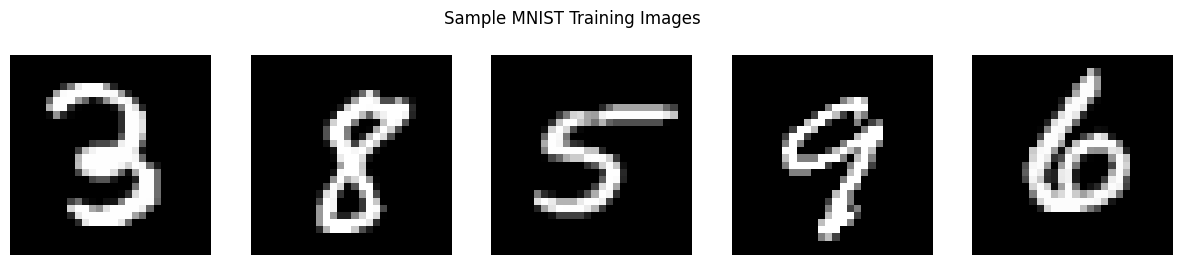

In [2]:
# Data Loading
print("Loading MNIST...")
X_train, Y_train, X_test, Y_test = mnist()
print(f"Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

# Visualize 5 random raw images
indices = np.random.randint(0, len(X_train), 5)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_train[int(indices[i])].numpy().reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.suptitle("Sample MNIST Training Images")
plt.show()

In [3]:
# Model Definition
# Architecture: Conv2d -> Relu -> MaxPool -> Conv2d -> Relu -> MaxPool -> Flatten -> Linear

class Model:
    def __init__(self):
        # Layer 1: 1 input channel (grayscale), 32 filters, 3x3 kernel
        self.l1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        # Layer 2: 32 input channels, 64 filters, 3x3 kernel
        self.l2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Layer 3: Fully connected.
        # 28x28 -> (pool) -> 14x14 -> (pool) -> 7x7.
        # With padding=1, size is preserved before pool.
        # 64 channels * 7 * 7 = 3136 features.
        self.l3 = nn.Linear(64 * 7 * 7, 10)

    def __call__(self, x):
        x = self.l1(x).relu().max_pool2d(2)
        x = self.l2(x).relu().max_pool2d(2)
        x = x.flatten(1)
        return self.l3(x)

model = Model()

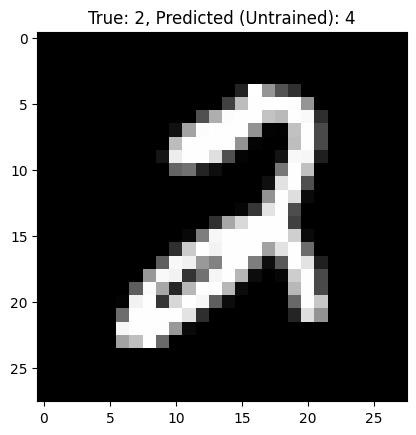

In [4]:
# The "Before" Test
# Pick a random image from test set
test_idx = np.random.randint(0, len(X_test))
test_img = X_test[test_idx]
test_label = Y_test[test_idx].item()

# Run untrained model
# Add batch dimension: (28, 28) -> (1, 1, 28, 28)
out = model(test_img.reshape(1, 1, 28, 28))
pred = out.argmax(axis=1).item()

plt.imshow(test_img.numpy().reshape(28, 28), cmap='gray')
plt.title(f"True: {test_label}, Predicted (Untrained): {pred}")
plt.show()

Starting training...
Step    0: Loss 24.9091, Acc 8.61%
Step  128: Loss 0.1269, Acc 95.60%
Step  256: Loss 0.0774, Acc 96.85%
Step  384: Loss 0.0630, Acc 97.35%
Step  512: Loss 0.0321, Acc 97.51%
Step  640: Loss 0.0679, Acc 97.76%
Step  768: Loss 0.1617, Acc 98.05%
Step  896: Loss 0.0177, Acc 97.38%


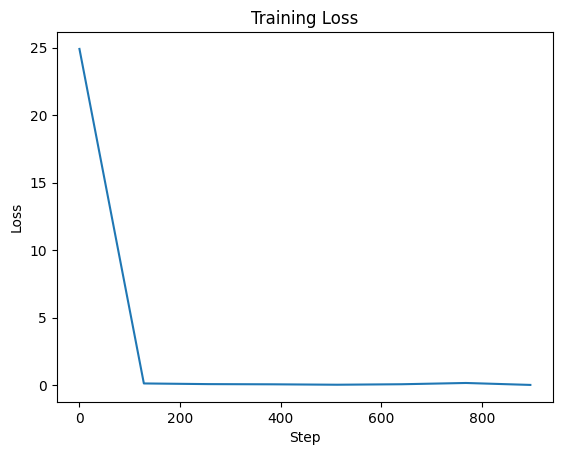

In [5]:
# Training Loop

opt = nn.optim.Adam(nn.state.get_parameters(model))
batch_size = 128
steps = 1024

@TinyJit
def train_step(X: Tensor, Y: Tensor) -> Tensor:
    Tensor.training = True
    opt.zero_grad()
    out = model(X)  # Forward pass: get predictions
    loss = out.sparse_categorical_crossentropy(Y)  # Compare predictions to ground truth
    loss.backward()
    opt.step()
    return loss

losses = []

print("Starting training...")
for i in range(steps):
    # Sample random batch
    samples = Tensor.randint(batch_size, high=X_train.shape[0])
    X, Y = X_train[samples], Y_train[samples]
    
    loss = train_step(X, Y)

    if i % batch_size == 0:
        Tensor.training = False
        acc = (model(X_test).argmax(axis=1) == Y_test).mean().item()
        loss_val = loss.item()
        losses.append(loss_val)
        print(f"Step {i:4d}: Loss {loss_val:.4f}, Acc {acc * 100.0:.2f}%")

# Plot training progress
plt.plot(range(0, steps, batch_size), losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

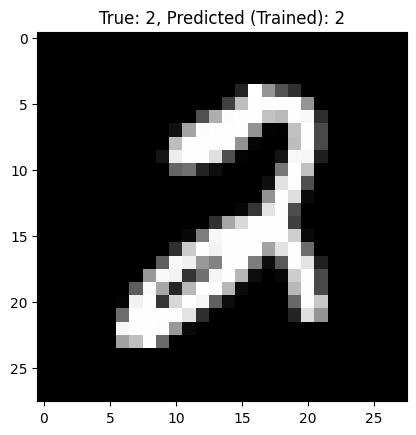

In [6]:
# The "After" Test
# Run trained model on the same image
out_trained = model(test_img.reshape(1, 1, 28, 28))
pred_trained = out_trained.argmax(axis=1).item()

plt.imshow(test_img.numpy().reshape(28, 28), cmap='gray')
plt.title(f"True: {test_label}, Predicted (Trained): {pred_trained}")
plt.show()